In [1]:
# Import moduls
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import keras.losses as kl
from tensorflow.keras.callbacks import EarlyStopping

from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [2]:
path = '../data/processed/combined_data_with_elasticity.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1, parse_dates=True)


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\3118146038.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1, parse_dates=True)


## Classes for training the models

In [3]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [4]:
class Model_pred_error(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0
        self.eta = 0.9

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)
        y_start_predicted = self.model_start.predict(feat_start.loc[:, self.columns + ['Mondelez']])
        
        feat_middle = X.copy()
        target_middle = (y-self.eta * y_start_predicted).loc[~mask_f]
        
        self.model_middle.fit( feat_middle.loc[~mask_f,self.columns + ['Mondelez', 'Ferrero']],target_middle)
        y_middle_predicted = self.model_middle.predict(feat_middle.loc[~mask_f & ~mask_l,self.columns + ['Mondelez', 'Ferrero']])
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end =( y-self.eta * y_start_predicted).loc[~mask_f & ~mask_l] 
        target_end = target_end - self.eta**2 * y_middle_predicted

        self.model_end.fit(feat_end.loc[:, self.columns + ['Mondelez', 'Ferrero','LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()

        result['pred_m'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[~mask_f, self.columns + ['Mondelez', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_middle.loc[~mask_f & ~mask_l,  self.columns + ['Mondelez', 'Ferrero', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.eta + result.loc[~mask_f & mask_l, 'pred_mf'] 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.eta + result.loc[~mask_l,'pred_mf'] * self.eta**2 + result.loc[~mask_l,'pred_mfl']
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [5]:
def preprocessing(df, dict_lag,number_train, target_name):
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    col_with_target = columns
    if target_name not in columns: 
        col_with_target.append(target_name)
    df_selected_col = df.loc[:, shares + col_with_target]
    df_selected_col = df_selected_col.dropna(subset = target_name)
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    ohe_tranf = ColumnTransformer(transformers = [  ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
                                                      ['month'])], 
                                     remainder = 'passthrough', verbose_feature_names_out = False)
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('ohe', ohe_tranf),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    return features_train_transf, features_test_transf, target_train, target_test, columns

In [ ]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name = 'Model', model_simple =0):
    # Train Test split
    features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

    # Model
    #columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    if model_simple == 0:
        mod = Model( columns,
             model_start, model_middle, 
             model_end)
    else: 
       mod = Model_pred_error( columns,
             model_start, model_middle, 
             model_end) 
    #print(features_train_transf.columns.values )
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    last_train_df = results.iloc[-1,:]
    last_train_df = pd.DataFrame(last_train_df).transpose()
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
  
    #print('vorher', results_test)
    results_test = pd.concat([last_train_df, results_test])
    #print('nachher', results_test)

    color_target = 'darkred'
    color_final = 'darkgreen'
    color_m = 'purple'
    color_mf = 'lightblue'
    color_mfl = 'pink'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm', alpha = 0.5, color =color_m)#, color = 'blue');
    ax.plot(results.index,results.pred_mf.values, label = 'mf', alpha = 0.5, color =color_mf)#, color = 'lightblue');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl', alpha = 0.5, color =color_mfl)#, color = 'green');
    ax.plot(results.index,results.final.values, label = 'final', color = color_final)#, color = 'purple');
    ax.plot(results.index, results.target,  label = target_name, color = color_target);
    
    ax.axvline(pd.to_datetime('2021-04-30'), linestyle = ':', linewidth = 2)#, color = 'red')
    ax.axvline(pd.to_datetime('2024-11-30'), linestyle = ':', linewidth = 2)#, color = 'red')
    plt.xticks(rotation=90)
    ax.set_title(name)
    
    # Predict testdata 
    ax.plot(results_test.index, results_test.target,  label = target_name + ' Test',  color = color_target, linestyle = '--')
    
    #fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results_test.index,results_test.pred_m.values, label = 'm' + ' Test', alpha = 0.5, linestyle = '--', color =color_m)#, color = 'blue');
    ax.plot(results_test.index,results_test.pred_mf.values, label = 'mf' + ' Test', alpha = 0.5, linestyle = '--', color =color_mf)#, color = 'lightblue');
    ax.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl' + ' Test', alpha = 0.5, linestyle = '--', color =color_mfl)#, color = 'green');
    ax.plot(results_test.index,results_test.final.values, label = 'final' + ' Test', linestyle = '--', color = color_final)#, color = 'purple');
    #ax_test.plot(results_test.index,results_test.target, label = target_name)#, color = 'orange');
    #plt.xticks(rotation=90)
    #ax_test.set_title(name + ' on test set')
    #ax_test.legend()
    ax.legend()
    return results, results_test
    

## Cacao elasticity

In [7]:
columns = [
 #'ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg',
 #'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 #'ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade)',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen', 
 #'VPI_Süßwaren',
 #'VPI_Kakaopulver oder Ähnliches',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_cacao'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
dict_lag.update({'Mondelez': [0,1,2,3]})
for k in [ #'Umsatz_WZ08-1082',
          #'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 #'VPI_Süßwaren',
 #'VPI_Kakaopulver oder Ähnliches',
 'PCOCOUSDM',
 'PCOFFROBUSDM', 
 'elasticity_cacao']:
    dict_lag.update({k: [1]})

for k in [
 #'ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg',
 #'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 #'ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade)',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg', 
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [0,1]})


<Axes: >

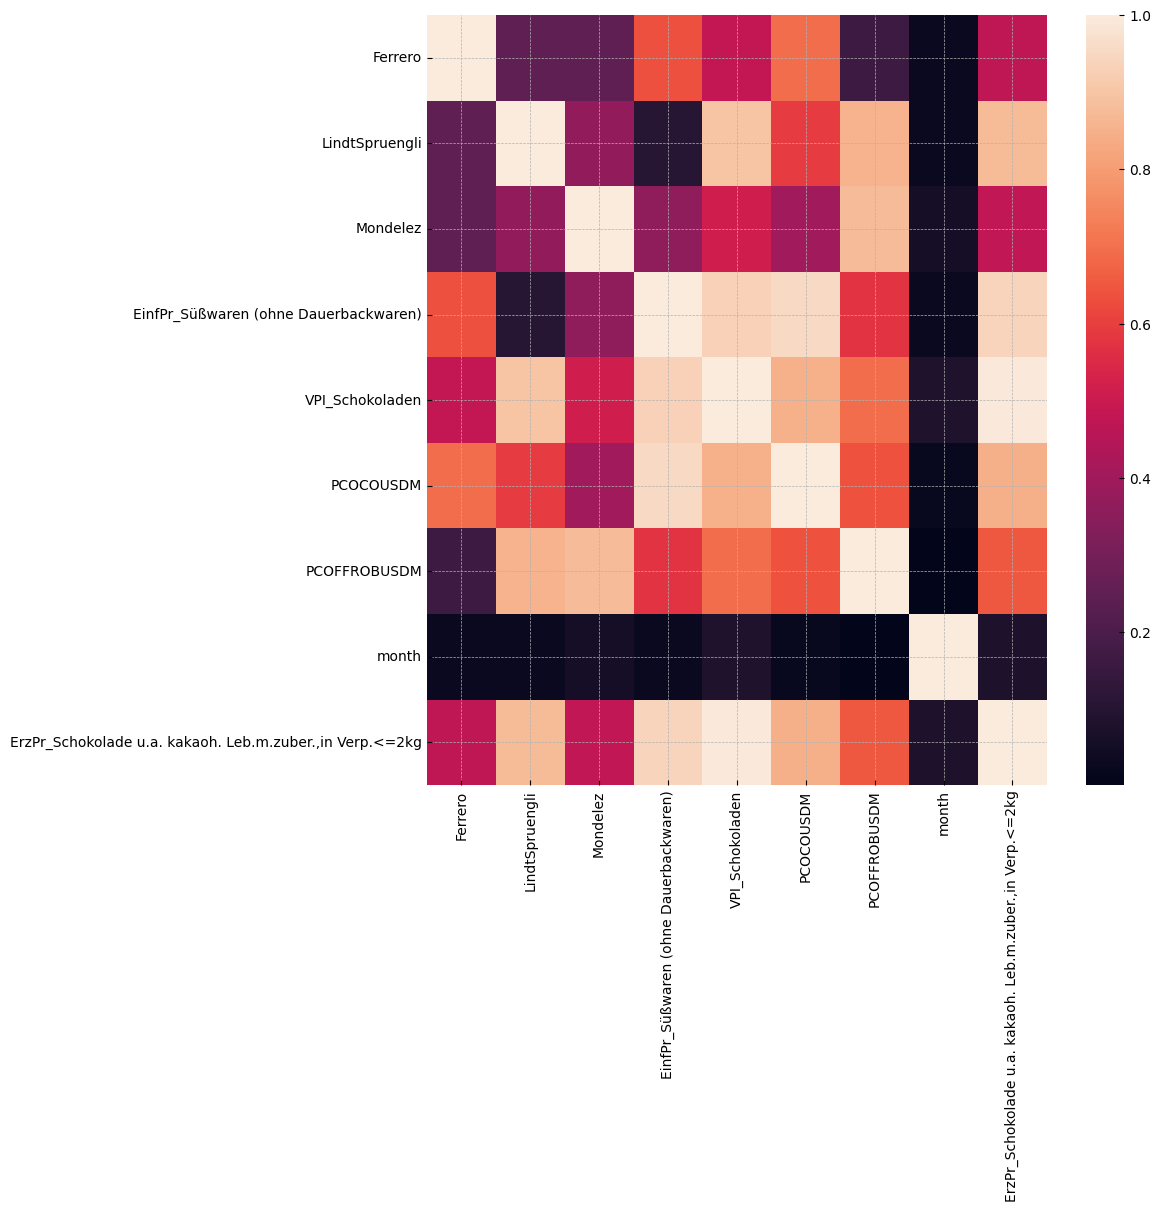

In [53]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

MSE on Train set:  35.265001060801225
MSE on Test set:  200.63487017754704
MSE on Train set:  25.88634870866349
MSE on Test set:  198.09544176744646


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.20718677   0.09774447  -1.44071533  -5.92068608  -0.08829321
  -2.5037086    1.18162851   2.68391195   6.50410286  -4.01668357
   2.90341321  -1.9250117    2.44875918   1.49258148   5.45954777
 -11.66437182  -2.73924998  -3.24843534  -0.75794575   2.3597813
   8.25288664  -5.00273403   0.71051373   0.05191679  -0.32550246
   0.50591696  -7.01647322]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -1.61901318  -3.45612238   3.23478461  -5.76909955   0.03399956
   3.38708489  -1.10427678 -14.13616

(              pred_m   pred_mf  pred_mfl      final     target
 index                                                         
 2019-01-31  0.207187       NaN       NaN   0.207187   0.207187
 2019-02-28  0.097744       NaN       NaN   0.097744   2.208051
 2019-03-31 -1.440715       NaN       NaN  -1.440715  -0.367747
 2019-04-30 -5.920686       NaN       NaN  -5.920686  -1.450762
 2019-05-31 -0.088293       NaN       NaN  -0.088293  -0.543008
 ...              ...       ...       ...        ...        ...
 2024-10-31  3.133264 -3.929770       NaN  -1.109832   1.749173
 2024-11-30  9.251086 -0.973136 -7.231405   0.306333   0.306333
 2024-12-31  7.265704  7.005148  8.221107  20.434410  20.434410
 2025-01-31  1.546918 -0.053841  0.429620   1.778236   1.778236
 2025-02-28 -2.468584  1.029445  2.951167   1.563292   1.563292
 
 [74 rows x 5 columns],
                pred_m   pred_mf  pred_mfl      final     target
 2025-02-28  -2.468584  1.029445  2.951167   1.563292   1.563292
 2025-03-31 

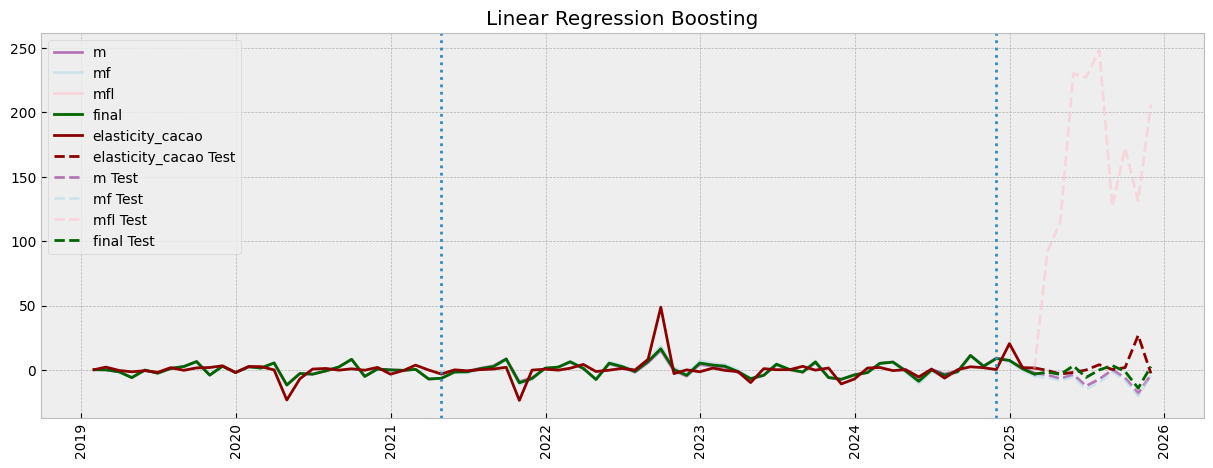

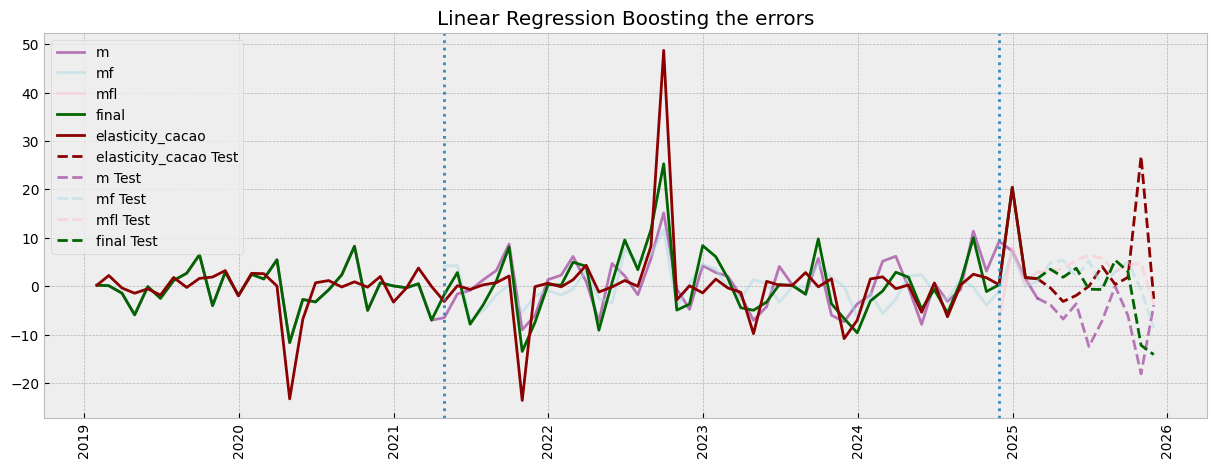

In [8]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()

name = 'Linear Regression Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear Regression Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


## LinearSVR

MSE on Train set:  53.70766894713566
MSE on Test set:  101.58702622207797
MSE on Train set:  46.429400977638736
MSE on Test set:  105.52174938773227


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.20535819  0.87873596 -0.37106352 -1.85398298 -0.37393282  0.25017908
  0.76699892  0.55027101  1.61833696 -0.11324305  0.19268066 -2.01329043
  1.46513993  2.15868577  0.04214609 -2.58542689 -0.93457694 -0.42091799
 -0.15926993  0.53108912  1.66061565 -0.19394359  0.07745851 -1.87813126
  1.05288973  0.77880192 -1.05745931]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.97078806 -0.91903042  0.81960312 -0.1967937  -0.13248723  0.15416191
 -0.14325481 -2.74815166 -2.06183955]' has dtype incompa

(              pred_m   pred_mf   pred_mfl      final     target
 index                                                          
 2019-01-31  0.206653       NaN        NaN   0.206653   0.207187
 2019-02-28  0.879709       NaN        NaN   0.879709   2.208051
 2019-03-31 -0.368756       NaN        NaN  -0.368756  -0.367747
 2019-04-30 -1.862849       NaN        NaN  -1.862849  -1.450762
 2019-05-31 -0.371659       NaN        NaN  -0.371659  -0.543008
 ...              ...       ...        ...        ...        ...
 2024-10-31  1.750436  0.171141        NaN   1.746533   1.749173
 2024-11-30  1.807487  0.405014  -1.648838   0.305962   0.306333
 2024-12-31  0.902149  2.177514  17.858109  20.433829  20.434410
 2025-01-31  1.782852  0.175946   0.031153   1.778236   1.778236
 2025-02-28  1.710464  0.017133   0.009548   1.562843   1.563292
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl      final     target
 2025-02-28  1.710464  0.017133  0.009548   1.562843   1.563292
 

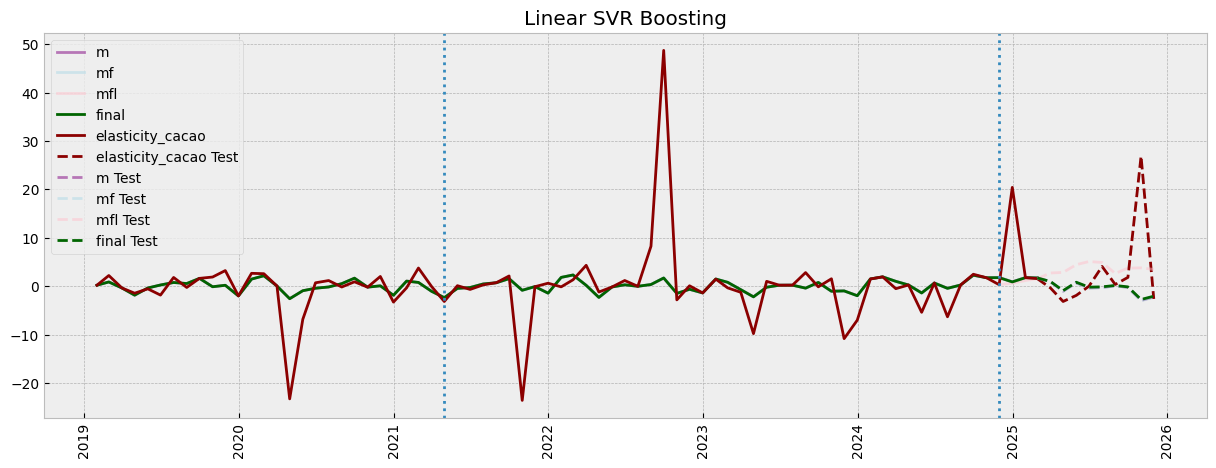

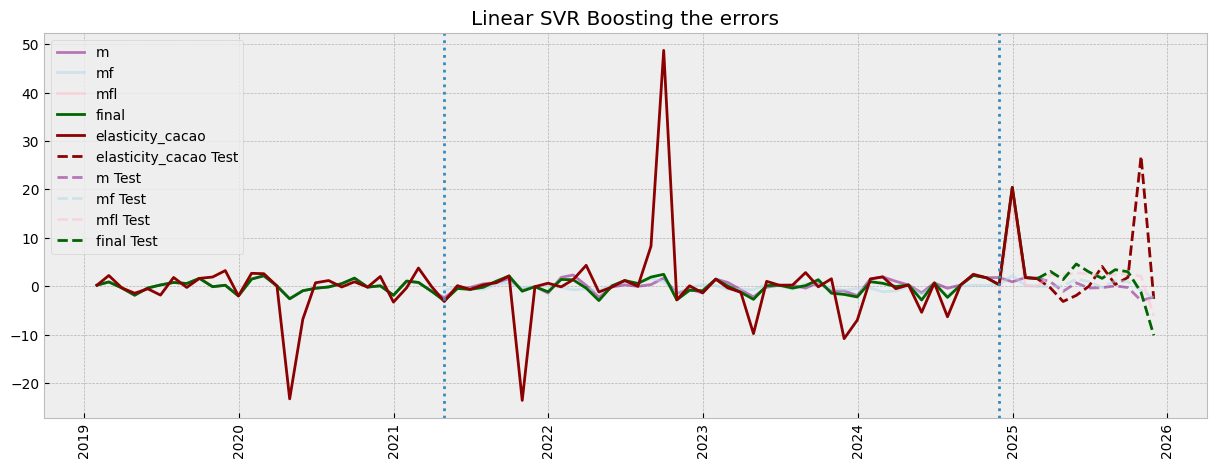

In [9]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()


name = 'Linear SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


MSE on Train set:  55.21009331748587
MSE on Test set:  78.91799103399505
MSE on Train set:  53.385132707341675
MSE on Test set:  78.49824989800479


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.10726907  1.62754054 -0.26773475 -1.3510642  -0.44304733 -0.14283258
  0.63613601  0.01907739  1.08357971 -0.08087634  0.88203643 -1.02312131
  0.05213128  1.67749553 -0.03666689 -1.48656971 -0.70638992 -0.10568609
  0.62628718 -0.0641144   1.00978125 -0.10079453  0.8379296  -1.02854345
  0.03501939  1.69464554 -0.16248752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.41430403 0.72059481 0.57490778 0.97628329 0.46631526 0.69979798
 1.11005015 1.11906329 0.52871925]' has dtype incompatible wit

(              pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 2019-01-31  0.107269       NaN       NaN  0.107269   0.207187
 2019-02-28  1.627541       NaN       NaN  1.627541   2.208051
 2019-03-31 -0.267735       NaN       NaN -0.267735  -0.367747
 2019-04-30 -1.351064       NaN       NaN -1.351064  -1.450762
 2019-05-31 -0.443047       NaN       NaN -0.443047  -0.543008
 ...              ...       ...       ...       ...        ...
 2024-10-31  1.649134  0.297859       NaN  1.782080   1.749173
 2024-11-30  0.406129 -0.159304  0.170232  0.406712   0.306333
 2024-12-31  1.116315  0.428520  0.898269  2.250054  20.434410
 2025-01-31  1.678406  0.167751  0.231602  1.878046   1.778236
 2025-02-28  1.463713  0.145684  0.227756  1.663102   1.563292
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final     target
 2025-02-28  1.463713  0.145684  0.227756  1.663102   1.563292
 2025-03-31  0.439737 -0.0291

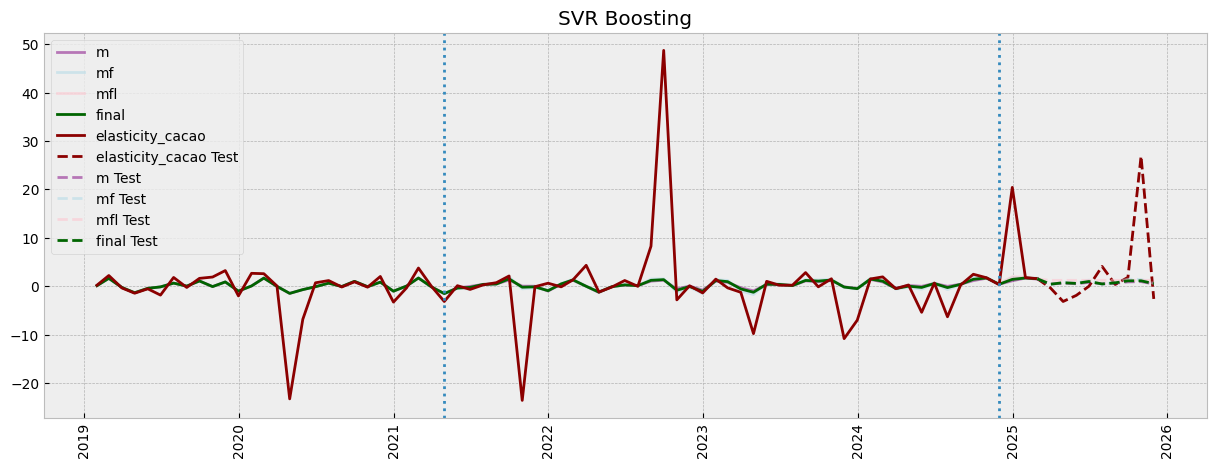

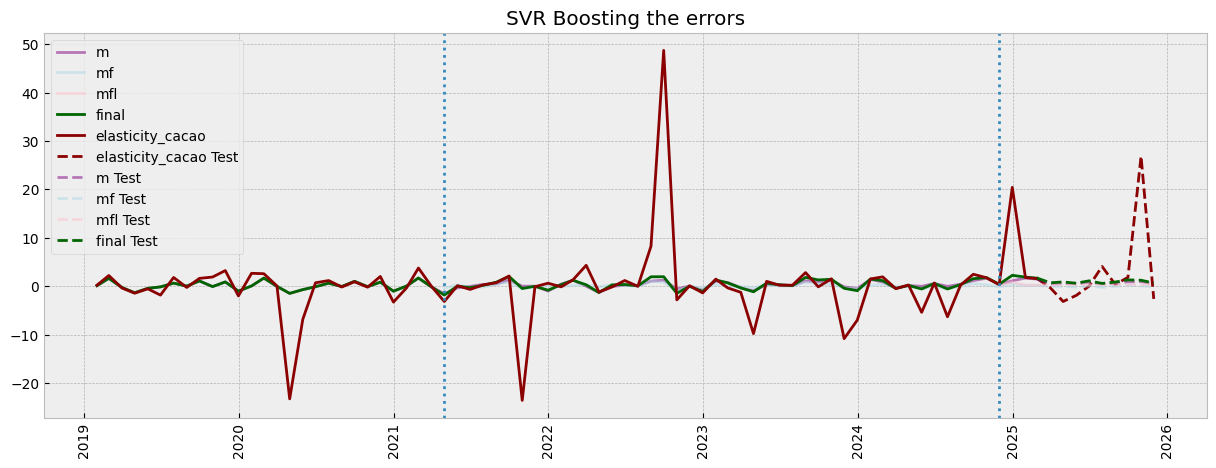

In [10]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()

name = 'SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


## Random Forest

MSE on Train set:  14.32943843325412
MSE on Test set:  112.01439697623465
MSE on Train set:  8.507531759018452
MSE on Test set:  90.18516100222075


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.39385514  -4.30662217  -1.37573667  -9.72072563  -4.30662217
  -4.21418023   0.55520025   0.21346063   0.76903507  -0.42466486
   0.14424711  -0.61119612   0.46989555  -0.03197349  -0.61119612
 -23.29519975  -3.49741141   0.46989555  -4.09804233   0.55520025
   0.55520025   0.63448303   0.84668136  -1.20642997   0.46989555
   0.46989555  -9.83934525]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.93565918  6.73808887  6.93565918  6.28152868  6.93565918  6.88407927
  6.93565918  6.98929996 13.

(               pred_m   pred_mf  pred_mfl      final     target
 index                                                          
 2019-01-31   0.484625       NaN       NaN   0.484625   0.207187
 2019-02-28   0.484625       NaN       NaN   0.484625   2.208051
 2019-03-31  -5.821343       NaN       NaN  -5.821343  -0.367747
 2019-04-30 -10.521040       NaN       NaN -10.521040  -1.450762
 2019-05-31   0.484625       NaN       NaN   0.484625  -0.543008
 ...               ...       ...       ...        ...        ...
 2024-10-31  -0.502714  1.526783       NaN   1.074340   1.749173
 2024-11-30   0.255272 -1.274077  1.108590   0.306333   0.306333
 2024-12-31  20.434410 -1.862663  1.108590  17.990802  20.434410
 2025-01-31   5.469734  3.878090 -6.285778   1.778236   1.778236
 2025-02-28   7.026253 -3.352469 -6.285778  -2.677651   1.563292
 
 [74 rows x 5 columns],
                pred_m   pred_mf  pred_mfl      final     target
 2025-02-28   7.026253 -3.352469 -6.285778  -2.677651   1.563292

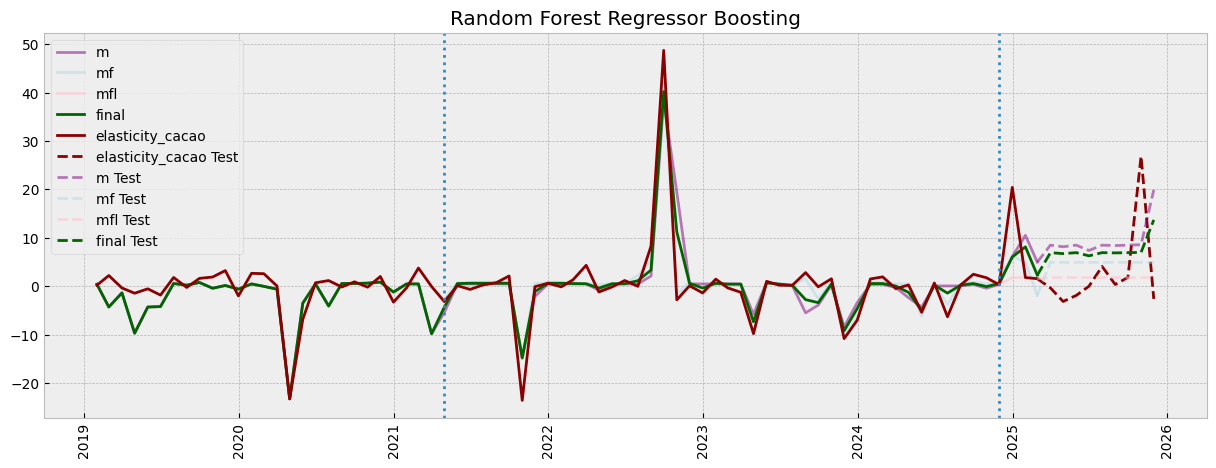

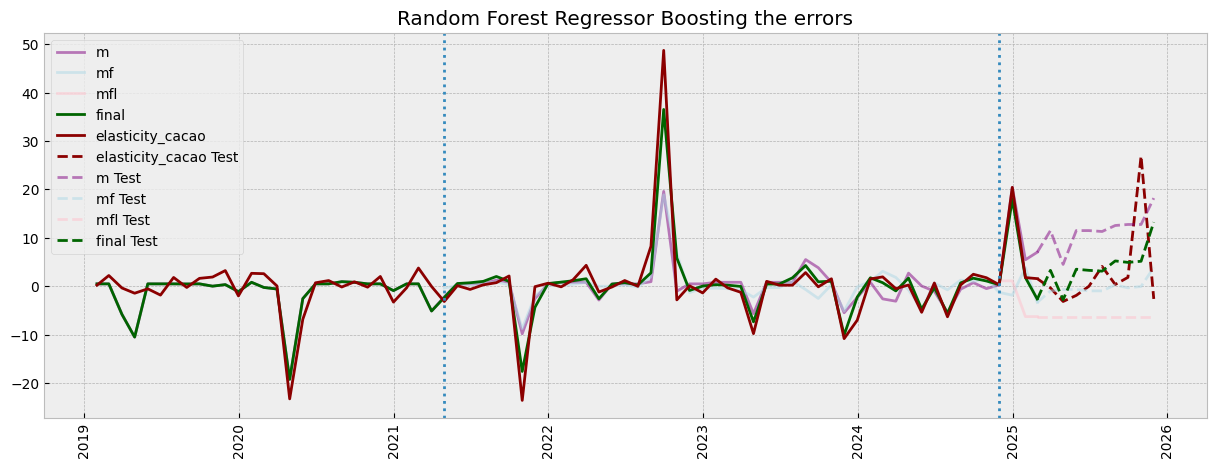

In [11]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)

name = 'Random Forest Regressor Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Random Forest Regressor Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### ANN

In [15]:
for share in shares:
    del dict_lag[share]

In [16]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

Epoch 1/50


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.0987 - val_loss: 83.2971
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.7334 - val_loss: 83.0957
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.7388 - val_loss: 82.2192
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.5317 - val_loss: 82.1025
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.7304 - val_loss: 79.8794
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.6731 - val_loss: 79.4708
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52.0434 - val_loss: 78.7612
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50.5869 - val_loss: 76.6329
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.8610 - val_loss: 75.5624
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.6622 - val_loss: 73.4762
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.3605 - val_loss: 75.1056
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.6

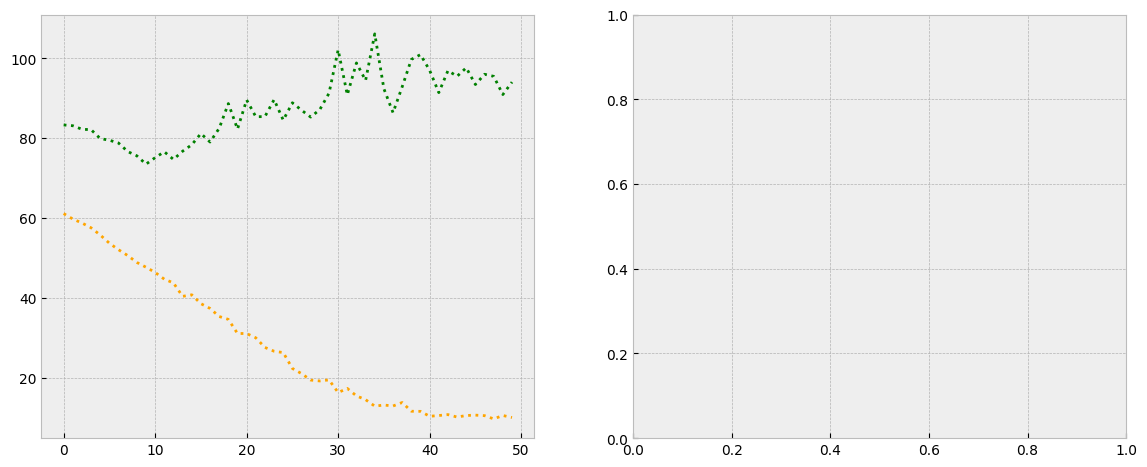

In [17]:
model_an = Sequential()
model_an.add(Dense(50,  activation="relu", input_shape=(features_train_transf.shape[1],)))#activation='sigmoid',
#model_an.add(Dense(500, activation = 'relu'))
model_an.add(Dense(20, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mse,
                optimizer = 'adam',
                #metrics = ["mae"]
                )  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=50, 
                    batch_size=1,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE on Train set:  8.910210076647884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MSE on Test set:  94.0271549219188


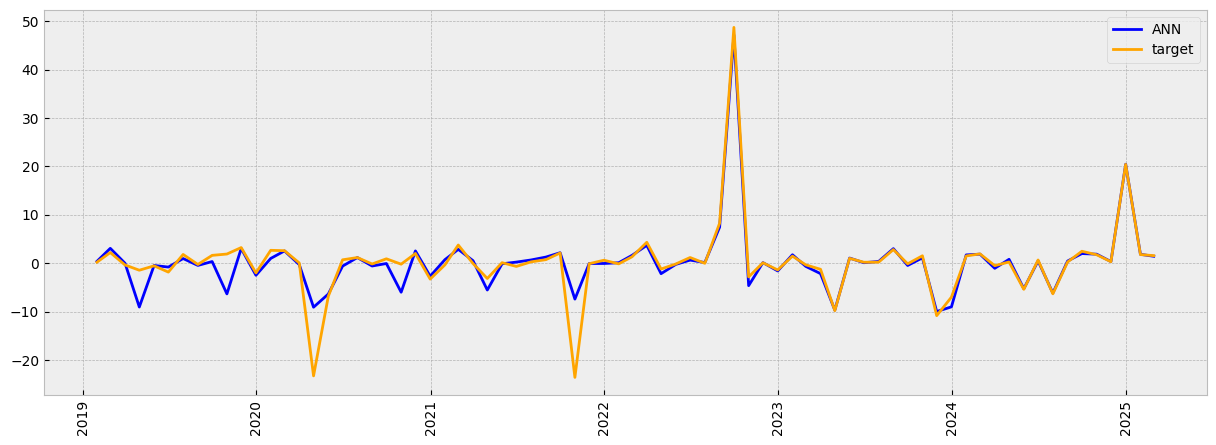

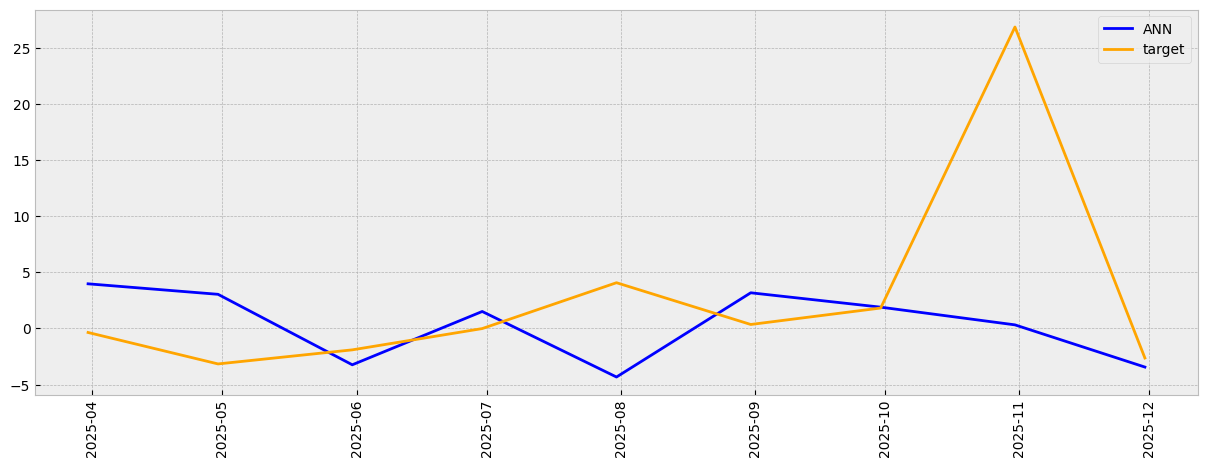

In [18]:

results = model_an.predict(features_train_transf)
print('MSE on Train set: ', mean_squared_error(results, target_train))
#results['target']=target_train
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(target_train.index,results, label = 'ANN', color = 'blue');
ax.plot(target_train.index, target_train,  label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax.legend()
# Predict testdata 
results_test = model_an.predict(features_test_transf)
#results_test['target']=target_test
print('MSE on Test set: ', mean_squared_error(results_test, target_test))
fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax_test.plot(target_test.index,results_test, label = 'ANN', color = 'blue');
ax_test.plot(target_test.index,target_test, label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax_test.legend()

## Coffee elasticity

In [ ]:
columns = [
 #'ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg',
 #'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 #'ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade)',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen', 
 #'VPI_Süßwaren',
 #'VPI_Kakaopulver oder Ähnliches',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_cacao'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
dict_lag.update({'Mondelez': [0,1,2,3]})
for k in [ #'Umsatz_WZ08-1082',
          #'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 #'VPI_Süßwaren',
 #'VPI_Kakaopulver oder Ähnliches',
 'PCOCOUSDM',
 'PCOFFROBUSDM', 
 'elasticity_cacao']:
    dict_lag.update({k: [1]})

for k in [
 #'ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg',
 #'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 #'ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade)',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg', 
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [0,1]})


In [24]:
df.columns.values[96]

'VPI_Kaffee und Ähnliches'

In [25]:
target_name = 'elasticity_coffee'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [
 'EinfPr_Kaffee und Tee, Kaffee-Ersatz',
 'VPI_Kaffee und Ähnliches', 
 'elasticity_coffee']:
    dict_lag.update({k: [1]})

for k in [
 'month',
 'ErzPr_Kaffee und Tee, Kaffee-Ersatz', 
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [0,1]})

### Linear Regression

MSE on Train set:  18.97121409417144
MSE on Test set:  3.449948557206442
MSE on Train set:  17.806497893489126
MSE on Test set:  2.753147918773128


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.25501081e-02 -5.24461267e+00 -2.57555085e-01 -1.33928267e+00
 -3.01662214e-01  1.35718680e+00  1.71789045e-01  1.29870123e-01
  4.24893435e-01 -4.26690890e-01  2.62706171e+00  1.88157669e+00
  7.14683791e-02 -3.24661618e+00  1.16925517e+00 -3.27829498e-01
  1.15378254e-01 -1.17846643e-01  6.26560839e-01  5.99692136e-02
  2.54421937e-03 -5.95053485e-01  2.29740099e+00  1.19270792e+00
  2.21836551e+00 -4.80709420e+00  4.59996146e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.30258836 -2.045

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31  0.092550       NaN       NaN  0.092550  0.092550
 2019-02-28 -5.244613       NaN       NaN -5.244613  6.430267
 2019-03-31 -0.257555       NaN       NaN -0.257555 -0.744450
 2019-04-30 -1.339283       NaN       NaN -1.339283 -0.002626
 2019-05-31 -0.301662       NaN       NaN -0.301662 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31  1.446696 -0.954837       NaN  0.347190  0.203823
 2024-11-30  1.444671  0.374190 -1.646341 -0.043044 -0.043044
 2024-12-31  1.519942 -2.167234  0.066547 -0.320965 -0.320965
 2025-01-31 -0.248085  0.435704  0.959839  1.089483  1.089483
 2025-02-28 -2.661433  2.915049 -0.192122 -0.226222 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 2025-02-28 -2.661433  2.915049 -0.192122 -0.226222 -0.226222
 2025-03-31  2.877176 -2.510963  0.111404  0

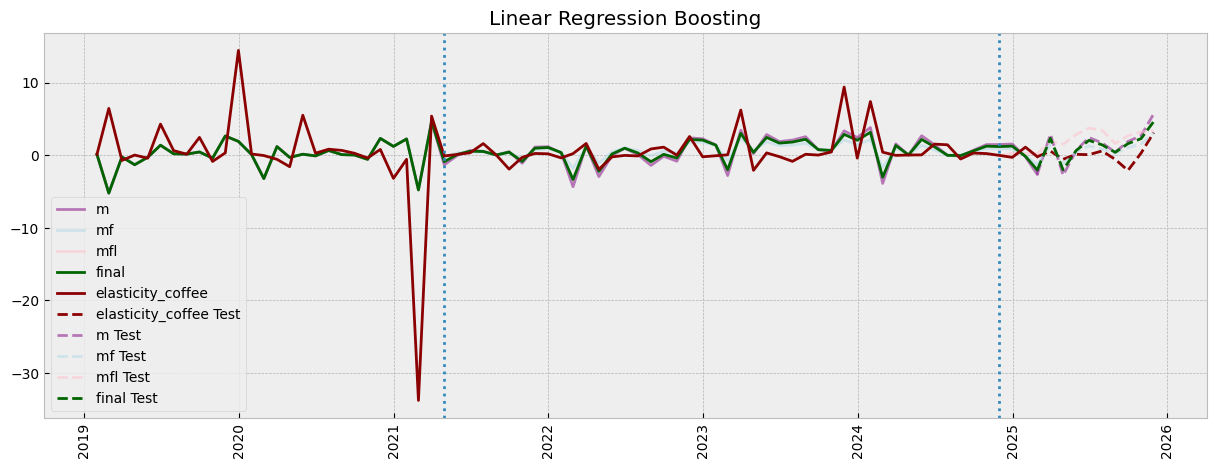

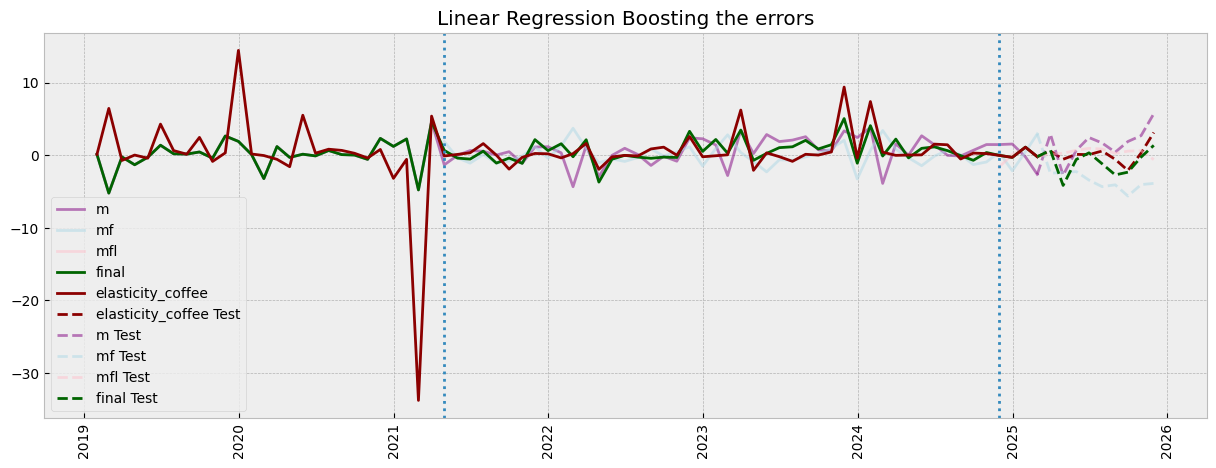

In [26]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()

name = 'Linear Regression Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear Regression Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### Linear SVR


MSE on Train set:  22.6855958872556
MSE on Test set:  1.7298777505490746
MSE on Train set:  22.380072814495712
MSE on Test set:  2.2680560228794158


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.09163618  0.67033945 -0.74454068 -0.75945916  0.13004084  0.22501442
  0.22319774  0.02757657  0.18530883 -0.27954732  0.56908734  0.19024602
 -1.74178098 -0.06858728 -0.08612892 -0.95655702  0.35375208 -0.31483799
  0.80589213  0.08961298  0.11209333 -0.15811813  0.42386629  0.2567886
  0.57783835  0.55873683  4.54742918]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.59322008 -1.9285526  -0.22075157 -0.45937592 -0.15342365 -0.19946329
 -0.06330127  0.02654693  0.43249608]' has dtype incompat

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31  0.091353       NaN       NaN  0.091353  0.092550
 2019-02-28  0.672662       NaN       NaN  0.672662  6.430267
 2019-03-31 -0.745221       NaN       NaN -0.745221 -0.744450
 2019-04-30 -0.754848       NaN       NaN -0.754848 -0.002626
 2019-05-31  0.127685       NaN       NaN  0.127685 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31 -0.129013  0.303847       NaN  0.187736  0.203823
 2024-11-30  0.588392 -0.053506 -0.529225 -0.043012 -0.043044
 2024-12-31  0.597362 -0.425254 -0.514049 -0.320878 -0.320965
 2025-01-31 -0.204670  0.100351  1.192402  1.089483  1.089483
 2025-02-28 -0.223374 -0.024594 -0.005180 -0.226138 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 2025-02-28 -0.223374 -0.024594 -0.005180 -0.226138 -0.226222
 2025-03-31 -0.592554  0.731231  0.261104  0

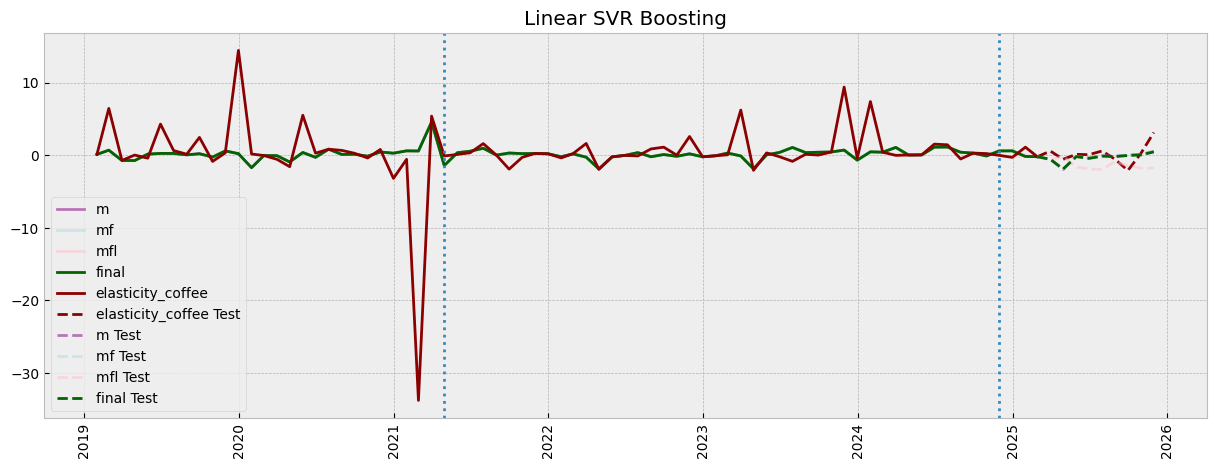

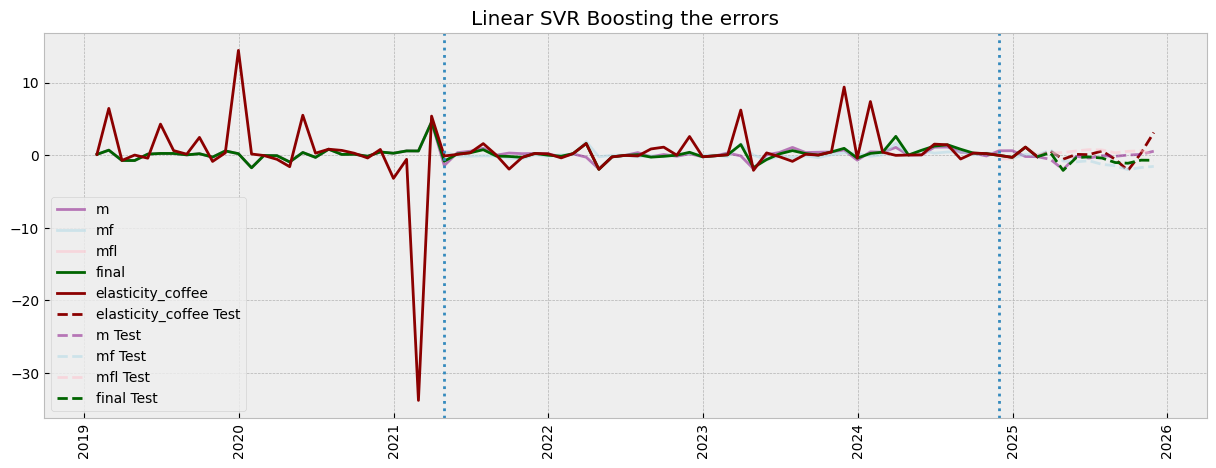

In [27]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()


name = 'Linear SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### SVR

MSE on Train set:  22.05930356932253
MSE on Test set:  1.5708282018144522
MSE on Train set:  21.76630007328301
MSE on Test set:  1.6380380709602342


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00720174  0.10333955 -0.58661168 -0.10252447  0.00328157  0.44455701
  0.66387094  0.21664824  0.21373382 -0.50501684  0.40295523  0.17492598
  0.04417066  0.03363624 -0.4617202  -0.13644707  0.03736961  0.35926357
  0.70465793  0.22319096  0.21352085 -0.486013    0.4039036   0.16196268
 -0.37532022  0.07605729  1.25572872]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.15378417 -0.15277447  0.11117061  0.23861856  0.19904572  0.04300048
  0.20454967  0.28687372  0.30777328]' has dtype incompa

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31 -0.007202       NaN       NaN -0.007202  0.092550
 2019-02-28  0.103340       NaN       NaN  0.103340  6.430267
 2019-03-31 -0.586612       NaN       NaN -0.586612 -0.744450
 2019-04-30 -0.102524       NaN       NaN -0.102524 -0.002626
 2019-05-31  0.003282       NaN       NaN  0.003282 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31  0.303968  0.030289       NaN  0.303860  0.203823
 2024-11-30  0.349938  0.023652 -0.277147  0.056956 -0.043044
 2024-12-31 -0.220548 -0.022572 -0.141327 -0.358104 -0.320965
 2025-01-31  0.973129  0.161260 -0.016954  0.989483  1.089483
 2025-02-28 -0.126079 -0.012479 -0.127089 -0.250669 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 2025-02-28 -0.126079 -0.012479 -0.127089 -0.250669 -0.226222
 2025-03-31  0.166911 -0.010081 -0.130443  0

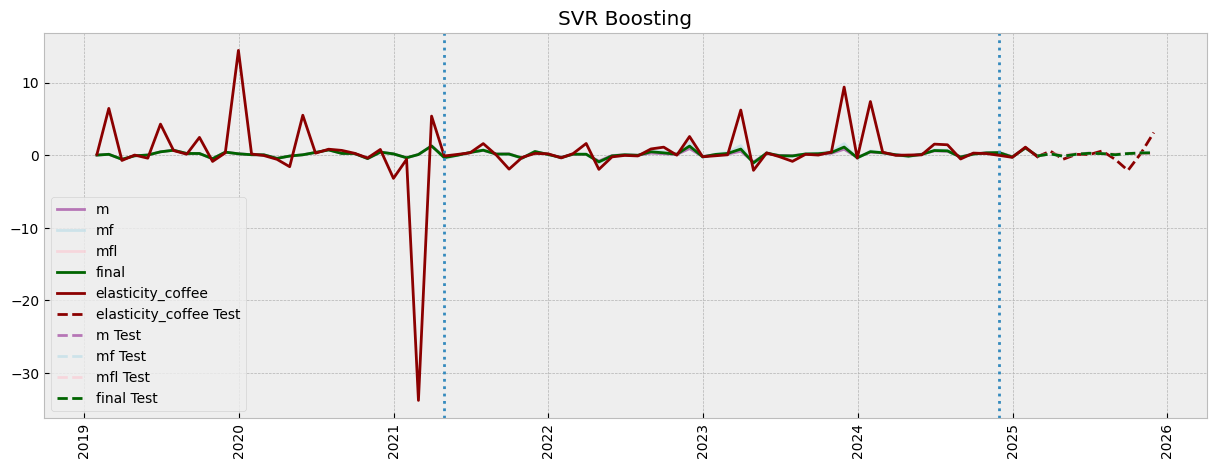

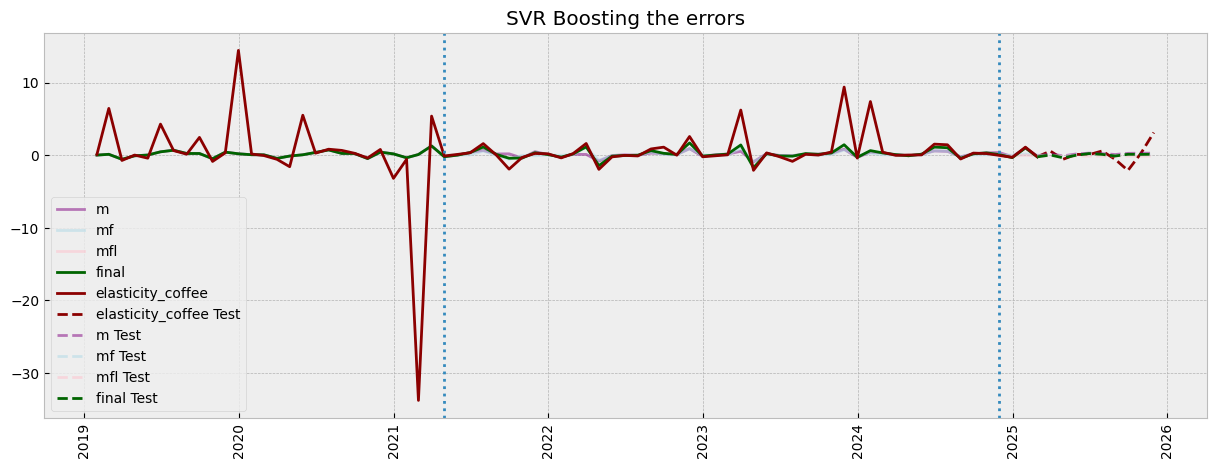

In [28]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()

name = 'SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### Random Forest

MSE on Train set:  8.775498394241888
MSE on Test set:  4.199208587935406
MSE on Train set:  8.659177992425441
MSE on Test set:  4.427212049920289


C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.37645969e-02  3.33040539e+00 -3.69541142e-01  1.72129493e-01
 -8.79541233e-03  2.70905533e+00  3.63104697e-02  4.82872287e-01
  8.65514798e-01 -2.36037347e-01 -2.00573711e-01  5.16786864e+00
  4.02639799e-02  4.17710454e+00 -3.11797540e-01 -1.00999171e+00
  2.14442269e+00  3.63104697e-02  1.01503711e+00  2.00762367e+00
  1.22630326e+00  1.08658412e+00  2.40870595e+00 -1.73365530e+00
 -3.25308061e-01 -1.23614316e+01  9.59048053e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_52488\555920208.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.87835972 1.21699

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31  0.023765       NaN       NaN  0.023765  0.092550
 2019-02-28  3.330405       NaN       NaN  3.330405  6.430267
 2019-03-31 -0.369541       NaN       NaN -0.369541 -0.744450
 2019-04-30  0.172129       NaN       NaN  0.172129 -0.002626
 2019-05-31 -0.008795       NaN       NaN -0.008795 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31  0.125389  0.556443       NaN  0.669293  0.203823
 2024-11-30  0.672995 -0.339255 -0.418783 -0.087884 -0.043044
 2024-12-31  0.125389 -0.018558 -0.418783 -0.320965 -0.320965
 2025-01-31  1.432332 -0.018558 -0.184584  1.089483  1.089483
 2025-02-28 -0.016844 -0.176241 -0.068307 -0.226222 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 2025-02-28 -0.016844 -0.176241 -0.068307 -0.226222 -0.226222
 2025-03-31  4.403341  1.214871 -0.068307  4

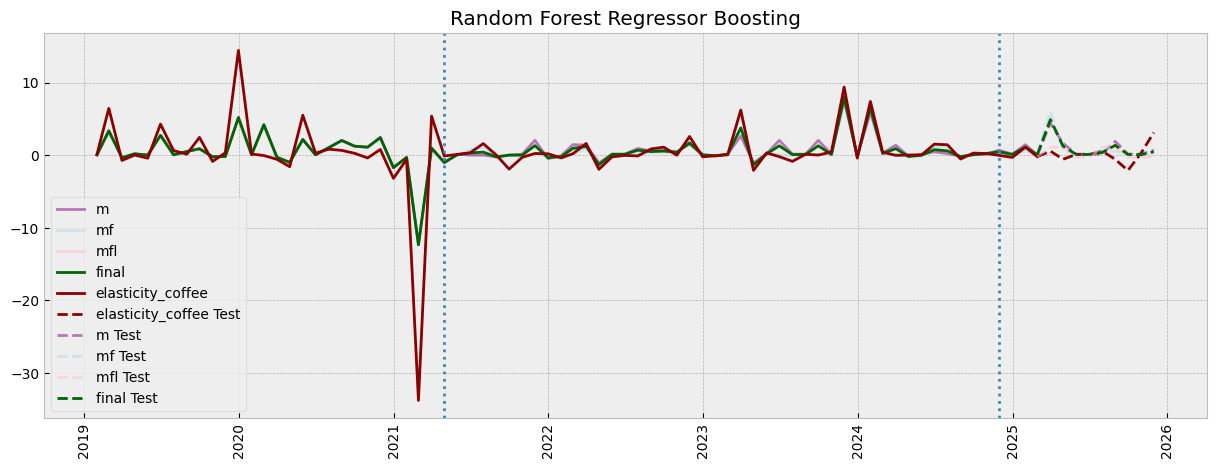

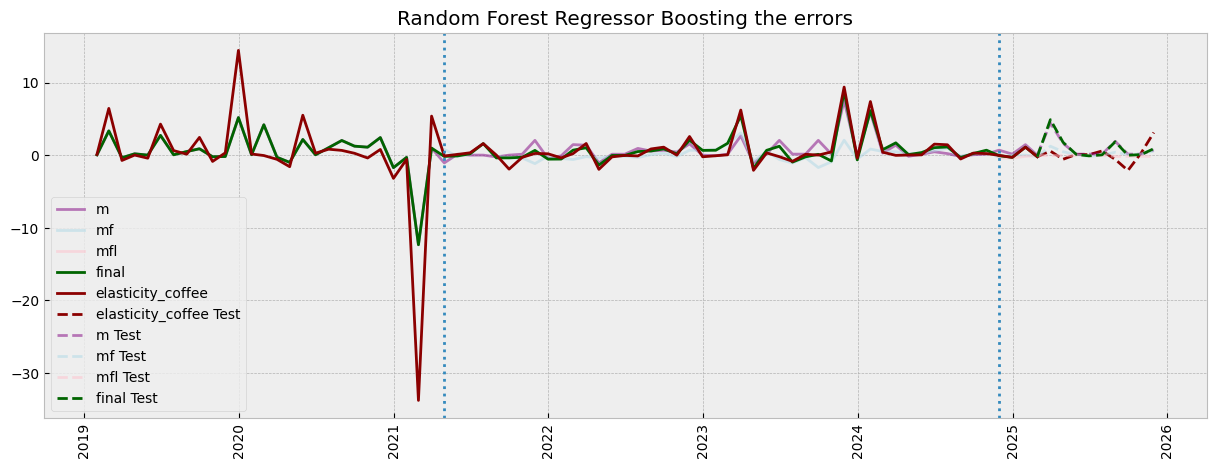

In [29]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5, random_state=42)

name = 'Random Forest Regressor Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Random Forest Regressor Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### ANN

In [31]:
for share in shares:
    del dict_lag[share]

In [32]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

Epoch 1/50


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 23.1210 - val_loss: 1.7483
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.9869 - val_loss: 2.0916
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.5100 - val_loss: 2.0357
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1430 - val_loss: 3.4408
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.9779 - val_loss: 3.8574
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.1695 - val_loss: 2.8704
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8900 - val_loss: 4.8820
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.5118 - val_loss: 3.7048
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9087 - val_loss: 4.3618
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.8289 - val_loss: 5.1493
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.5125 - val_loss: 1.8901
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.2846 - val_l

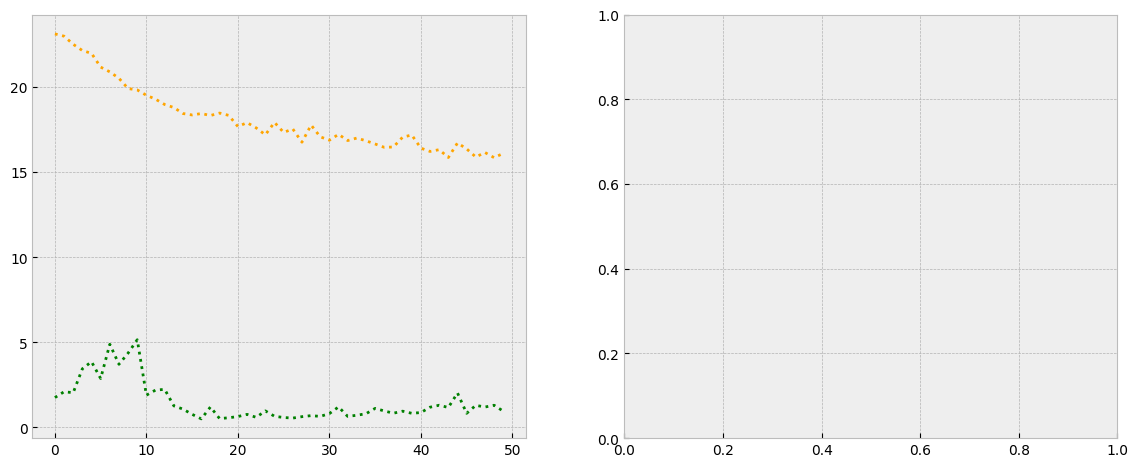

In [33]:
model_an = Sequential()
model_an.add(Dense(50,  activation="relu", input_shape=(features_train_transf.shape[1],)))#activation='sigmoid',
#model_an.add(Dense(500, activation = 'relu'))
model_an.add(Dense(20, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mse,
                optimizer = 'adam',
                #metrics = ["mae"]
                )  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=50, 
                    batch_size=1,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MSE on Train set:  15.043074629894516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MSE on Test set:  0.9502233236254809


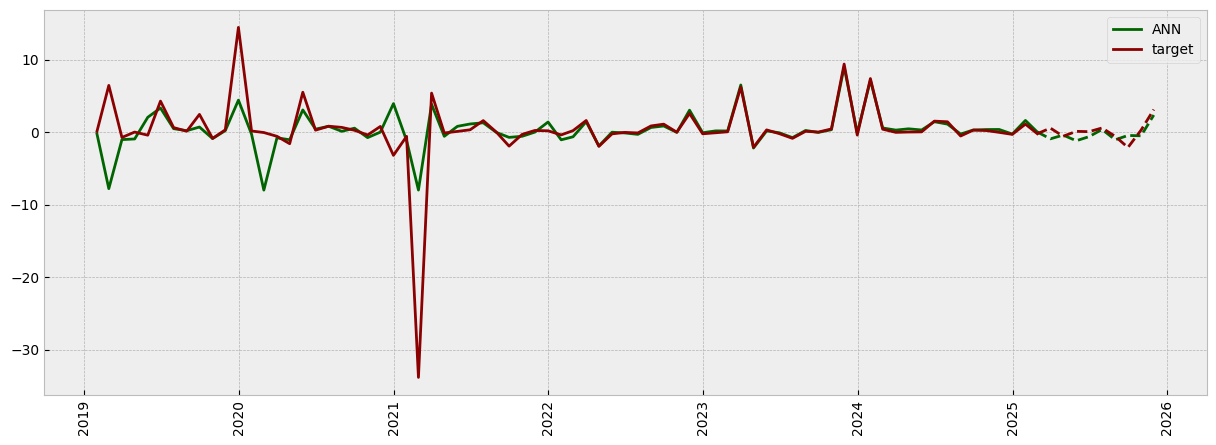

In [67]:

results = model_an.predict(features_train_transf)
print('MSE on Train set: ', mean_squared_error(results, target_train))
#results['target']=target_train



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
color_target = 'darkred'
color_ann = 'darkgreen'
ax.plot(target_train.index,results, label = 'ANN', color = color_ann);
ax.plot(target_train.index, target_train,  label = 'target', color = color_target);
plt.xticks(rotation=90)
ax.legend()
# Predict testdata 
results_test = model_an.predict(features_test_transf)
#results_test['target']=target_test
print('MSE on Test set: ', mean_squared_error(results_test, target_test))
value = results[-1]
value = value.tolist()[0]

results_list= results_test.tolist()
results_list.insert(0,[value])
#print(results_list)
value_date = target_train.index[-1]
#value_date = value.tolist()[0]

new_index = target_test.index
new_index= new_index.tolist()
new_index.insert(0,value_date)
#print(new_index)
#fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(new_index,results_list, label = 'ANN Test' , color = color_ann, linestyle = '--');
ax.plot(new_index,[target_train.values.tolist()[-1]] + target_test.values.tolist(), label = 'target Test', color = color_target, linestyle = '--');
#plt.xticks(rotation=90)
#ax_test.legend()

### ARIMAX

In [139]:
data = df.loc[:,'elasticity_coffee']
#data = data.asfreq('MS')
#data = data['litters']

In [140]:
data

date
2019-01-31    0.092550
2019-02-28    6.430267
2019-03-31   -0.744450
2019-04-30   -0.002626
2019-05-31   -0.432072
                ...   
2025-07-31    0.563849
2025-08-31   -0.593607
2025-09-30   -2.124554
2025-10-31    0.266662
2025-11-30    3.101441
Name: elasticity_coffee, Length: 83, dtype: float64

In [141]:
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Train dates : 2019-01-31 00:00:00 --- 2025-03-31 00:00:00  (n=75)
Test dates  : 2025-03-31 00:00:00 --- 2025-11-30 00:00:00  (n=9)


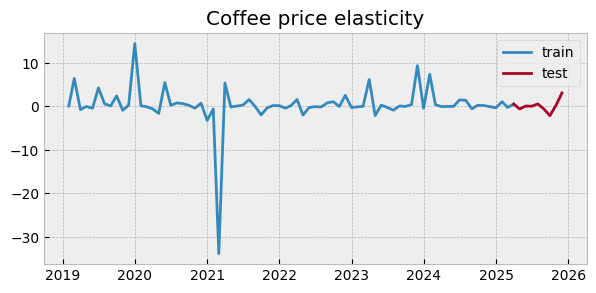

In [142]:
# Train-test dates
# ==============================================================================
end_train = '2025-03-31'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
#set_dark_theme()
fig, ax=plt.subplots(figsize=(7, 3))
ax.plot(data_train, label='train')
ax.plot(data_test, label='test')
ax.set_title('Coffee price elasticity')
ax.legend();

Test stationarity for original series
-------------------------------------
ADF Statistic: -9.978519985288937, p-value: 2.145410041713563e-17
KPSS Statistic: 0.10312428224040007, p-value: 0.1

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -6.983036658325007, p-value: 8.099705336866723e-10
KPSS Statistic: 0.11469174010081847, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -5.707002876207295, p-value: 7.448377463557587e-07
KPSS Statistic: 0.09960212899320262, p-value: 0.1


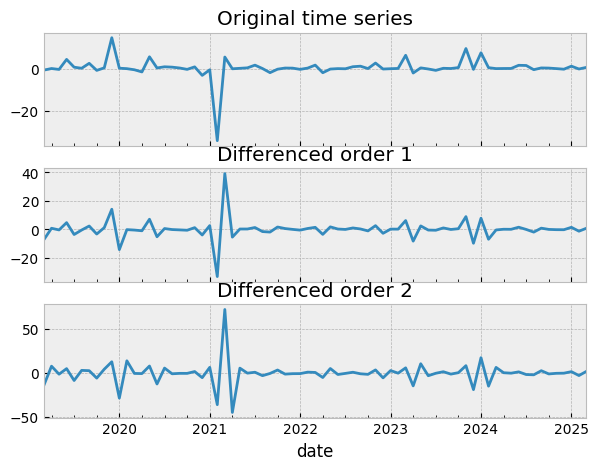

In [143]:
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

# Suppress warnings for stationarity tests
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    print('Test stationarity for original series')
    print('-------------------------------------')
    adfuller_result = adfuller(data)
    kpss_result = kpss(data)
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

    print('\nTest stationarity for differenced series (order=1)')
    print('--------------------------------------------------')
    adfuller_result = adfuller(data_diff_1)
    kpss_result = kpss(data.diff().dropna())
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

    print('\nTest stationarity for differenced series (order=2)')
    print('--------------------------------------------------')
    adfuller_result = adfuller(data_diff_2)
    kpss_result = kpss(data.diff().diff().dropna())
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

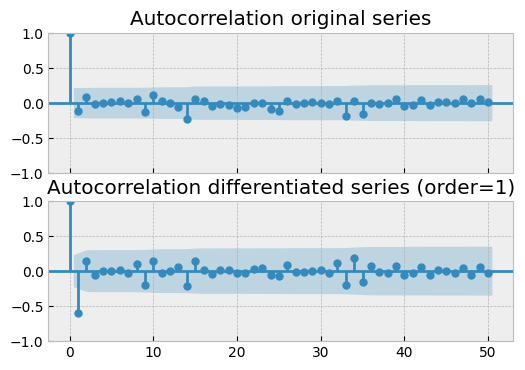

In [144]:
# Autocorrelation plot for original and differentiated series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)');

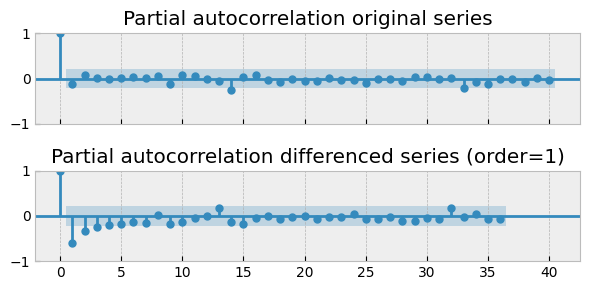

In [145]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=40, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=36, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

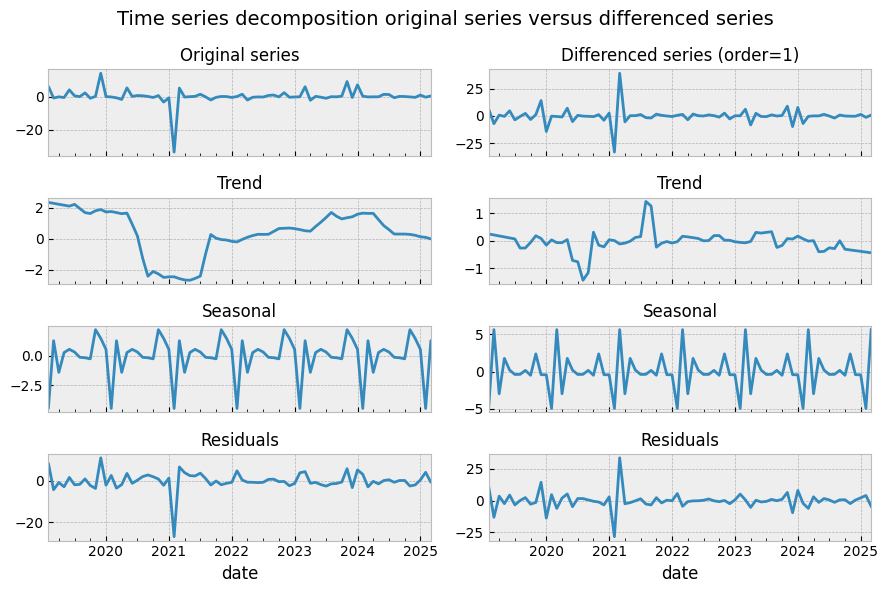

In [146]:
# Time series decomposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq', period=12)
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq', period=12)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time series decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

In [147]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
model_res.summary()

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  elasticity_coffee   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -199.726
Date:                            Tue, 24 Feb 2026   AIC                            409.452
Time:                                    09:34:09   BIC                            420.088
Sample:                                01-31-2019   HQIC                           413.628
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1583      0.115     -1.382      0.167      -0.383       0.066
ma.L1         -0.8701      0.109     -7.984      0.000      -1.084      -0.657
ar.S.L12       0.0330      0.179      0.184      0.854      -0.319       0.385
ma.S.L12      -0.9989    101.379     -0.010      0.992    -199.699     197.701
sigma2        25.3463   2566.211      0.010      0.992   -5004.335    5055.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               407.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
predictions_statsmodels.index

DatetimeIndex(['2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31',
               '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30',
               '2025-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [149]:
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme, plot_prediction_intervals
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.utils import expand_index
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, grid_search_stats


In [150]:
# ARIMA model with skforecast Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  elasticity_coffee   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -199.726
Date:                            Tue, 24 Feb 2026   AIC                            409.452
Time:                                    09:34:19   BIC                            420.088
Sample:                                01-31-2019   HQIC                           413.628
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1583      0.115     -1.382      0.167      -0.383       0.066
ma.L1         -0.8701      0.109     -7.984      0.000      -1.084      -0.657
ar.S.L12       0.0330      0.179      0.184      0.854      -0.319       0.385
ma.S.L12      -0.9989    101.379     -0.010      0.992    -199.699     197.701
sigma2        25.3463   2566.211      0.010      0.992   -5004.335    5055.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               407.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
# Prediction
# ==============================================================================
predictions_skforecast_sarimax = model.predict(steps=len(data_test))
predictions_skforecast_sarimax = pd.DataFrame(predictions_skforecast_sarimax, index=data_test.index)
predictions_skforecast_sarimax.columns = ['skforecast']
display(predictions_skforecast_sarimax.head(4))

,skforecast
date,
2025-03-31,NaN
2025-04-30,-0.779464
2025-05-31,0.741917
2025-06-30,0.998639


In [152]:
# ARIMA model with skforecast Arima
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train, suppress_warnings=True)
model.summary()

ARIMA Model Summary
Model     : Arima(1,1,1)(1,1,1)[12]
Method    : ARIMA(1,1,1)(1,1,1)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.5291  (SE:   0.2496, t:    -2.12)
  ma1            :    -0.6956  (SE:   0.2427, t:    -2.87)
  sar1           :    -0.1254  (SE:      nan, t:      nan)
  sma1           :    -0.3759  (SE:      nan, t:      nan)

Model fit statistics:
  sigma^2:             41.835945
  Log-likelihood:      -206.63
  AIC:                 423.26
  BIC:                 N/A

Residual statistics:
  Mean:                0.279552
  Std Dev:             5.913758
  MAE:                 3.330437
  RMSE:                5.880849

Time Series Summary Statistics:
Number of observations: 75
  Mean:                 0.3683
  Std Dev:              4.7910
  Min:                  -33.8220
  25%:                  -0.2464
  Median:               0.0926
  75%:                  0.7058
  Max:                  14.4284


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\skforecast\stats\_arima.py:1065: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(self.var_coef_[i, i])


In [153]:
# Prediction
# ==============================================================================
predictions_skforecast_arima = model.predict(steps=len(data_test))
#pred_index = expand_index(index=data_train.index, steps=len(data_test))
predictions_skforecast_arima = pd.Series(predictions_skforecast_arima, index=data_test.index)
predictions_skforecast_arima.head(4)


date
2025-03-31   -1.452699
2025-04-30   -1.022238
2025-05-31   -0.113180
2025-06-30   -0.520082
dtype: float64

In [160]:
.index

SyntaxError: invalid syntax (3312948729.py, line 1)

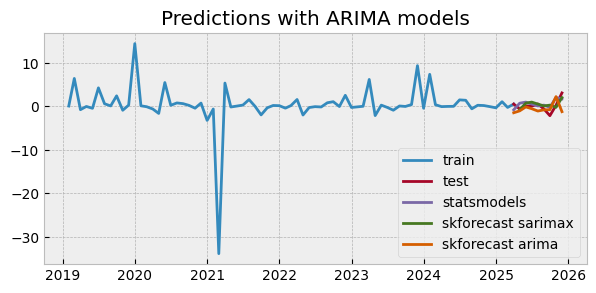

In [154]:


# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data_train, label='train')
ax.plot(data_test, label='test')
ax.plot(predictions_skforecast_sarimax.index, predictions_statsmodels.values, label='statsmodels')
ax.plot(predictions_skforecast_sarimax, label='skforecast sarimax')
ax.plot(predictions_skforecast_arima, label='skforecast arima')
ax.set_title('Predictions with ARIMA models')
ax.legend();
